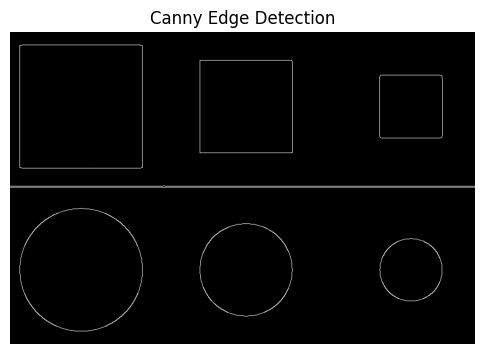

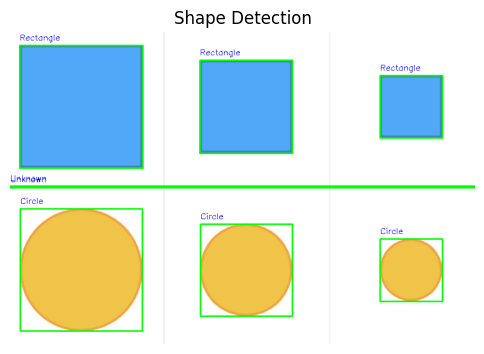

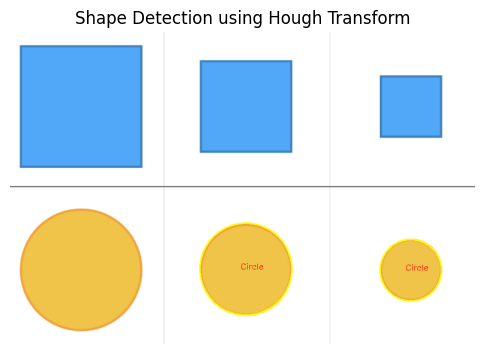

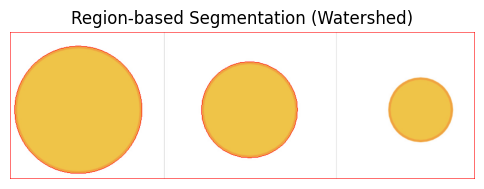

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, img, cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

# Load the image
image = cv2.imread('sample.png')  # replace with your image path
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 1. EDGE DETECTION: Canny
edges = cv2.Canny(blurred, 50, 150)
show_image("Canny Edge Detection", edges)

# 2. SHAPE DETECTION: Contours + Hough Transform for Circles
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_contours1 = image.copy()
image_contours2 = image.copy()
for c in contours:
    approx = cv2.approxPolyDP(c, 0.04 * cv2.arcLength(c, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.rectangle(image_contours1, (x, y), (x + w, y + h), (0, 255, 0), 2)
    shape = "Unknown"
    if len(approx) == 3:
        shape = "Triangle"
    elif len(approx) == 4:
        shape = "Rectangle"
    elif len(approx) > 4:
        shape = "Circle"
    cv2.putText(image_contours1, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
show_image("Shape Detection", cv2.cvtColor(image_contours1, cv2.COLOR_BGR2RGB), cmap=None)
# Detect Circles using Hough Transform
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.0, minDist=30,
                           param1=50, param2=30, minRadius=10, maxRadius=100)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :]:
        cv2.circle(image_contours2, (x, y), r, (0, 255, 255), 2)
        cv2.putText(image_contours2, 'Circle', (x-10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

show_image("Shape Detection using Hough Transform", cv2.cvtColor(image_contours2, cv2.COLOR_BGR2RGB), cmap=None)

# 3. REGION-BASED SEGMENTATION: Watershed
# Convert to grayscale and threshold

image = cv2.imread('sample2.png')  # replace with your image path
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labeling
ret, markers = cv2.connectedComponents(sure_fg)

# Add 1 to all labels so that sure background is not 0
markers = markers + 1

# Mark the unknown region with 0
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(image, markers)
segmented_image = image.copy()
segmented_image[markers == -1] = [0, 0, 255]  # mark boundaries with red

show_image("Region-based Segmentation (Watershed)", cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB), cmap=None)